In [163]:
import pandas as pd
from scipy.spatial import distance as dist
from datetime import timedelta
import numpy as np
from __future__ import division

In [2]:
def getTimeStamp(timeStamp):
    return pd.to_datetime(timeStamp)

def createDF(folderName):
    flow_df = pd.read_csv(folderName + 'flow.tsv', delimiter='\t', header=None)
    speed_df = pd.read_csv(folderName + 'speed.tsv', delimiter='\t', header=None)
    occupancy_df = pd.read_csv(folderName + 'occupancy.tsv', delimiter='\t', header=None)
    
    df = pd.DataFrame({'A' : []})
    del df['A']
    for col in flow_df:
        df[col] = pd.Series(data = list(zip(flow_df[col],speed_df[col], occupancy_df[col])))
    
    timeStamp_df = pd.read_csv(folderName + 'timestamp.tsv', delimiter='\t', header=None)
    df['timeStamp'] = getTimeStamp(timeStamp_df[0])
    return df

In [3]:
def containsNeg(vec):
    if(vec[0] < 0):
        return 1
    elif(vec[1] < 0):
        return 1
    elif(vec[2] < 0):
        return 1
    else:
        return 0

In [368]:
def getVecInTimePeriod(timeInterval, currTime, df):
    #print "Curr Time: ",currTime
    timeInterval = timedelta(minutes = timeInterval)
    startTime = currTime - timeInterval
    #print "Start Time: ",startTime
    endTime = currTime + timeInterval
    #print "End Time: ",endTime
    df = df[df['timeStamp'] >= startTime]
    return df[df['timeStamp'] <= endTime]

In [369]:
def combineScore(lane_p,zone_p,currVec):
    if(containsNeg(currVec)):
        print "Negative value found!"
        neg_counter += 1
        return 1
    else:
        return (LANE_WEIGHT * lane_p) + (ZONE_WEIGHT * zone_p)

In [371]:
#same lane calculations
def compareLaneData(currCol,currVec,df, distThreshold):
    row_index = df.index[0]
    num_rows = df.shape[0]
    max_index = row_index + num_rows
    #print "Num rows (includes curr): ",num_rows
    col_index = 0
    numVecGreater = 0
    while row_index < max_index:
        dist.euclidean(df[currCol][row_index], currVec)
        edist = dist.euclidean(df[currCol][row_index], currVec)
        #print "Row ",row_index," dist: ",edist
        if(edist > distThreshold):
            numVecGreater += 1
        row_index += 1
    totalVec = row_index - 1
    print "Total Vectors: ",totalVec
    print "Num Vectors (>): ",numVecGreater
    return numVecGreater/totalVec

#same zone calculations
def compareZoneData(currCol,currVec, df, distThreshold):
    print "CurrVec: ", currVec
    print "Current col: ", currCol
    num_rows=df.shape[0]
    total_cols=df.shape[1]
    check_cols=np.arange(total_cols-1)
    check_cols=np.delete(check_cols,currCol)
    row_index = df.index[0]
    max_index = row_index + num_rows
    col_index = 0
    numVecGreater = 0
    totalVec=0
    for col in check_cols:
        while row_index < max_index:
            edist = dist.euclidean(df[col][row_index], currVec)
            #print "Row ",row_index," Col ",col," dist: ",edist
            if(edist > distThreshold):
                numVecGreater += 1
            row_index += 1
            totalVec += 1
        row_index = df.index[0]
    print "Total Vectors: ",totalVec
    print "Num Vectors (>): ",numVecGreater
    return numVecGreater/totalVec

In [ ]:
#START
#do all
#load data
zone = createDF('../cleaning1/1160/')

In [370]:
result = getVecInTimePeriod(5, zone['timeStamp'][8], zone)
#result

# RUN THIS TO GET FINAL PROBS FOR A SINGLE ZONE (FOLDER). MAKE LOOP TO DO ALL. NO IDEA HOW LONG THIS WILL RUN FOR. NOTE: OPTIMIZE THRESHOLDS FIRST BEFORE RUNNING ALL? NEED TO WRITE A TEXT FILE OUTPUT FUNCTION

In [372]:
from __future__ import division

TIME_INT = 5 #mins
NUM_ROWS = zone1160.shape[0]
NUM_COLS = zone1160.shape[1] - 1
THRESH_DET=5
THRESH_ZONE=10
LANE_WEIGHT = 0.8
ZONE_WEIGHT = 0.2
neg_counter=0

print "Num rows: ",NUM_ROWS
print "Num cols: ",NUM_COLS

for row in np.arange(NUM_ROWS):
    currTime=zone['timeStamp'][row]
    snippet = getVecInTimePeriod(TIME_INT, currTime, zone) #kill 2 birds at once, do all vectors on row before grabbing new time group
    for col in np.arange(NUM_COLS):
        currCol=col
        currRow=row
        currVec=zone[currCol][currRow]
        lane_p=compareLaneData(currCol,currVec, snippet, THRESH_DET)
        zone_p=compareZoneData(currCol,currVec, snippet, THRESH_ZONE)
        #print "ROW: ",currRow," COL: ",currCol
        #print "Lane (p): ",lane_p
        #print "Zone (p): ",zone_p
        comb_p=combineScore(lane_p,zone_p,currVec)
        print "Comb (p): ",comb_p
 #END



Num rows:  3775351
Num cols:  3
Total Vectors:  4
Num Vectors (>):  1
CurrVec:  (8, 68.0, 3.0)
Current col:  0
Total Vectors:  10
Num Vectors (>):  5
Comb (p):  0.3
Total Vectors:  4
Num Vectors (>):  3
CurrVec:  (13, 67.0, 4.0)
Current col:  1
Total Vectors:  10
Num Vectors (>):  6
Comb (p):  0.72
Total Vectors:  5
Num Vectors (>):  1
CurrVec:  (9, 67.0, 4.0)
Current col:  0
Total Vectors:  12
Num Vectors (>):  6
Comb (p):  0.26
Total Vectors:  5
Num Vectors (>):  4
CurrVec:  (4, 60.0, 2.0)
Current col:  1
Total Vectors:  12
Num Vectors (>):  7
Comb (p):  0.756666666667


# Use this viz code to try and determine THRESH_LANE and THRESH_ZONE. Provides basic histogram and trends for spd, occup, and flow. NOTE: There is NO overall trend for the 'zone' comparison as there is for the within 'detector' comparsion. 

# Also, I am not sure how much insight this will provide you as the euclidean distance will be hard to set from just a visualization.

In [373]:
import matplotlib.pyplot as plt
%matplotlib inline

#VIZ DATA - To get a feel for the distribution of spd,occup, and flow values for x minus
ROW=100 #specific data point's row
COL=0 #specific data point's col
NUM_BINS=5 #histogram
NUM_PLOTS=4 #dont change
currVec=zone1160[COL][ROW] #curr vector
snippet = getVecInTimePeriod(TIME_INT, zone1160['timeStamp'][ROW], zone) #grabs time segment

#within detector metrics
def plotLaneHist(currCol,currVec, df):
    print "CURR VEC: ",currVec
    vals=np.arange(3) #iterator for columns
    row_index = df.index[0]
    num_rows = df.shape[0]
    max_index = row_index + num_rows
    col_index = 0
    plot=1; #for plt.subplot
    for measure in vals: #flow,spd,occup
        while row_index < max_index:
            loc=df[currCol][row_index][measure] #data value (eg. '67' mph)
            plt.subplot(1,NUM_PLOTS,plot) #plot hist
            fig=plt.hist(loc,bins=NUM_BINS)
            row_index += 1
            plt.ylim(0,5)
            if (plot==1):
                #flow
                plt.xlim(-50,260)
                plt.title('Flow')
                plt.subplot(1,NUM_PLOTS,4)
                all_flow=[x[0] for x in df[currCol][:]]
                plt.plot(np.arange(num_rows),all_flow,color='b') #all plots (4th fig)
                plt.ylim(-50,260)
                plt.title("ALL METRICS")
            if (plot==2):
                #spd
                plt.xlim(-50,150)
                plt.title('Spd')
                plt.subplot(1,NUM_PLOTS,4)
                all_flow=[x[1] for x in df[currCol][:]]
                plt.plot(np.arange(num_rows),all_flow,color='r')
                plt.ylim(-50,260)
                plt.title("ALL METRICS")
            if (plot==3):
                #occup
                plt.xlim(0,100)
                plt.title('Occup')
                plt.subplot(1,NUM_PLOTS,4)
                all_flow=[x[2] for x in df[currCol][:]]
                plt.plot(np.arange(num_rows),all_flow,color='k')
                plt.ylim(-50,260)
                plt.title("ALL METRICS")
        row_index = df.index[0]
        plot += 1

#within zone metrics
def plotZoneHist(currCol,currVec, df):
    print "CURR VEC: ",currVec
    vals=np.arange(3)
    row_index = df.index[0]
    num_rows = df.shape[0]
    max_index = row_index + num_rows
    total_cols=df.shape[1]
    check_cols=np.arange(total_cols-1)
    check_cols=np.delete(check_cols,currCol)
    col_index = 0
    plot=1;
    for measure in vals:
        for col in check_cols:
            while row_index < max_index:
                loc=df[col][row_index][measure]
                plt.subplot(1,NUM_PLOTS,plot)
                fig=plt.hist(loc,bins=NUM_BINS)
                row_index += 1
                plt.ylim(0,5)
                if (plot==1):
                    #flow
                    plt.xlim(-50,260)
                    plt.title('Flow')
                if (plot==2):
                    #spd
                    plt.xlim(-50,150)
                    plt.title('Spd')
                if (plot==3):
                    #occup
                    plt.xlim(0,100)
                    plt.title('Occup')
            row_index = df.index[0]
        plot += 1
        row_index = df.index[0]


CURR VEC:  (3, 63.0, 1.0)


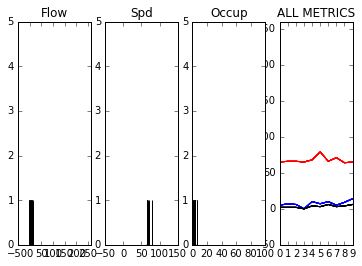

In [374]:
plotLaneHist(COL,currVec, result)


CURR VEC:  (3, 63.0, 1.0)


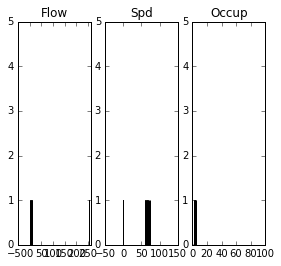

In [375]:
plotZoneHist(COL,currVec, result)
